# Multi-Class Text Classification for building Date Classifier with BERT

> In this notebook, I tried to use tex classification with BERT for predicting Dates of letters. I start with text preprocessing (special tokens, padding, and attention masks) and build a Date Classifier using the Transformers. 

In [1]:
!nvidia-smi

Thu Dec  8 22:22:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [74]:
# !pip install -q -U watermark

In [75]:
!pip install -qq transformers

In [76]:
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.0+cu116
transformers: 4.25.1



In [77]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda")

device

device(type='cuda', index=0)

## Data Exploration

We'll load the dataset:

In [78]:
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dati/rows.csv")

# df = pd.read_csv("./Data/rows.csv")
# df.head(1)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dati/Book1Copy.csv")
df.head()



,sender,addressee,from,testo,date,lettere
0,Iacopo Ammannati Piccolomini,Vespasiano da Bisticci,Montegufoni,"James, cardinal of Papia , greets Vespasian .\...",1444,41
1,Donato Acciaiuoli,Vespasiano da Bisticci,Montegufoni,"Vespasiano mio dolcissimo, le lettere le quali...",1446,1
2,Vespasiano da Bisticci,Filippo Podocataro,Firenze,"Vehementer me oblectant littere tue, Philippe ...",1444,2
3,Vespasiano da Bisticci,Filippo Podocataro,Firenze,"Paucis ante diebus respondidi litteris tuis, P...",1448,3
4,Vespasiano da Bisticci,Iohannes Caldarifex de Monthabur,Firenze,"Suscepi nuper litteras tuas, quibus nescio qui...",1448,4


In [79]:
df.shape

(23, 6)

Let's check for missing values:

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sender     23 non-null     object
 1   addressee  23 non-null     object
 2   from       23 non-null     object
 3   testo      23 non-null     object
 4   date       23 non-null     int64 
 5   lettere    23 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ KB


In [81]:
df = df.astype(object)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sender     23 non-null     object
 1   addressee  23 non-null     object
 2   from       23 non-null     object
 3   testo      23 non-null     object
 4   date       23 non-null     object
 5   lettere    23 non-null     object
dtypes: object(6)
memory usage: 1.2+ KB


In [83]:
# Create a new dataframe with two columns
train_raw = df[['testo', 'date']].copy()

# Remove missing values (NaN)
train_raw = train_raw[pd.notnull(train_raw['testo'])]

# Renaming second column for a simpler name
# train_raw.columns = ['', '']


In [84]:
# train_raw = train_raw[train_raw.testo.notnull()]

train_raw['len_txt'] =train_raw.testo.apply(lambda x: len(x.split()))
train_raw.describe()

,len_txt
count,23.000000
mean,296.695652
std,263.342576
min,62.000000
25%,156.000000
50%,214.000000
75%,309.000000
max,1278.000000


In [85]:
train_raw = train_raw[train_raw.len_txt >50]
train_raw.describe()

,len_txt
count,23.000000
mean,296.695652
std,263.342576
min,62.000000
25%,156.000000
50%,214.000000
75%,309.000000
max,1278.000000


In [86]:
train_raw

,testo,date,len_txt
0,"James, cardinal of Papia , greets Vespasian .\...",1444,302
1,"Vespasiano mio dolcissimo, le lettere le quali...",1446,173
2,"Vehementer me oblectant littere tue, Philippe ...",1444,180
3,"Paucis ante diebus respondidi litteris tuis, P...",1448,79
4,"Suscepi nuper litteras tuas, quibus nescio qui...",1448,139
5,Quamquam impresentiarum nihil haberem quod ad ...,1446,118
6,Ad epistolam tuam nuper accepi mihi impresenti...,1446,205
7,Reverende in Christo pater et domine mi singul...,1449,142
8,"Egli è più dì ch'io ricevetti una tua, alla qu...",1449,1278
9,"Dici non potest, Vespasiane suavissime, quantu...",1450,747


In [87]:
years=train_raw.date.values.tolist()
# year_names = ['1444', '1446', '1448', '1449', '1450']

train_raw['letter_date'] = years

In [88]:
train_raw = train_raw[['testo', 'letter_date']]
train_raw.reset_index(inplace=True, drop=True)
# train_raw["date"] = pd.to_datetime(train_raw["date"]).dt.strftime('%Y')

train_raw.head(2)

,testo,letter_date
0,"James, cardinal of Papia , greets Vespasian .\...",1444
1,"Vespasiano mio dolcissimo, le lettere le quali...",1446


In [89]:
df2 = train_raw.copy()

In [90]:
df2 = df2.reindex(np.random.permutation(df2.index))

Cleaning the text:

In [91]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)
  return text

In [92]:
df2['testo']  = df2.testo.apply(clean_txt)
df2.head(5)

,testo,letter_date
15,Avendo ne giorni passati facto risposta a una ...,1450
9,Dici non potest Vespasiane suavissime quantum ...,1450
0,James cardinal of Papia greets Vespasian Dear ...,1444
8,Egli è più dì chio ricevetti una tua alla qual...,1449
17,Honorevole come fratello et cetera Quanto più ...,1446


In [93]:
df2.reset_index(drop=True, inplace=True)
df2.head(5)

,testo,letter_date
0,Avendo ne giorni passati facto risposta a una ...,1450
1,Dici non potest Vespasiane suavissime quantum ...,1450
2,James cardinal of Papia greets Vespasian Dear ...,1444
3,Egli è più dì chio ricevetti una tua alla qual...,1449
4,Honorevole come fratello et cetera Quanto più ...,1446


In [94]:
from importlib.metadata import version
version('seaborn')

'0.11.2'

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


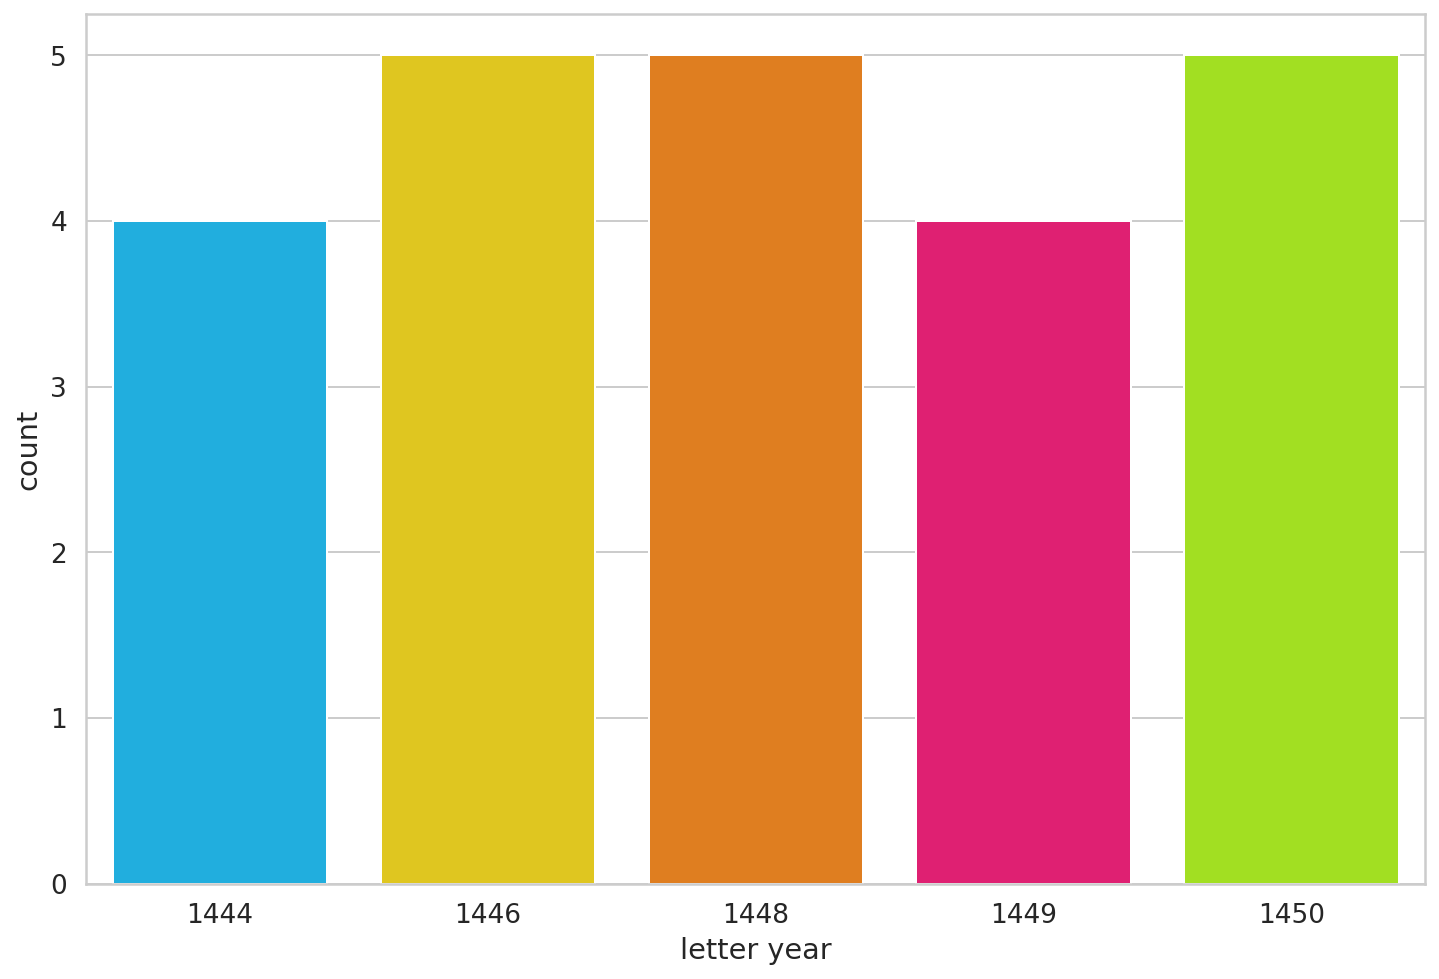

In [95]:
sns.countplot(df2.letter_date)
plt.xlabel('letter year');

It was highly imbalanced, 
but I changed the csv manually before to have a balanced data. I faced problems with imbalanced classfication. Here the dataset is converted into different years:

In [96]:
possible_labels = df2.letter_date.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{1450: 0, 1444: 1, 1449: 2, 1446: 3, 1448: 4}

In [97]:
class_names = ['1450', '1444', '1449', '1446', '1448']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


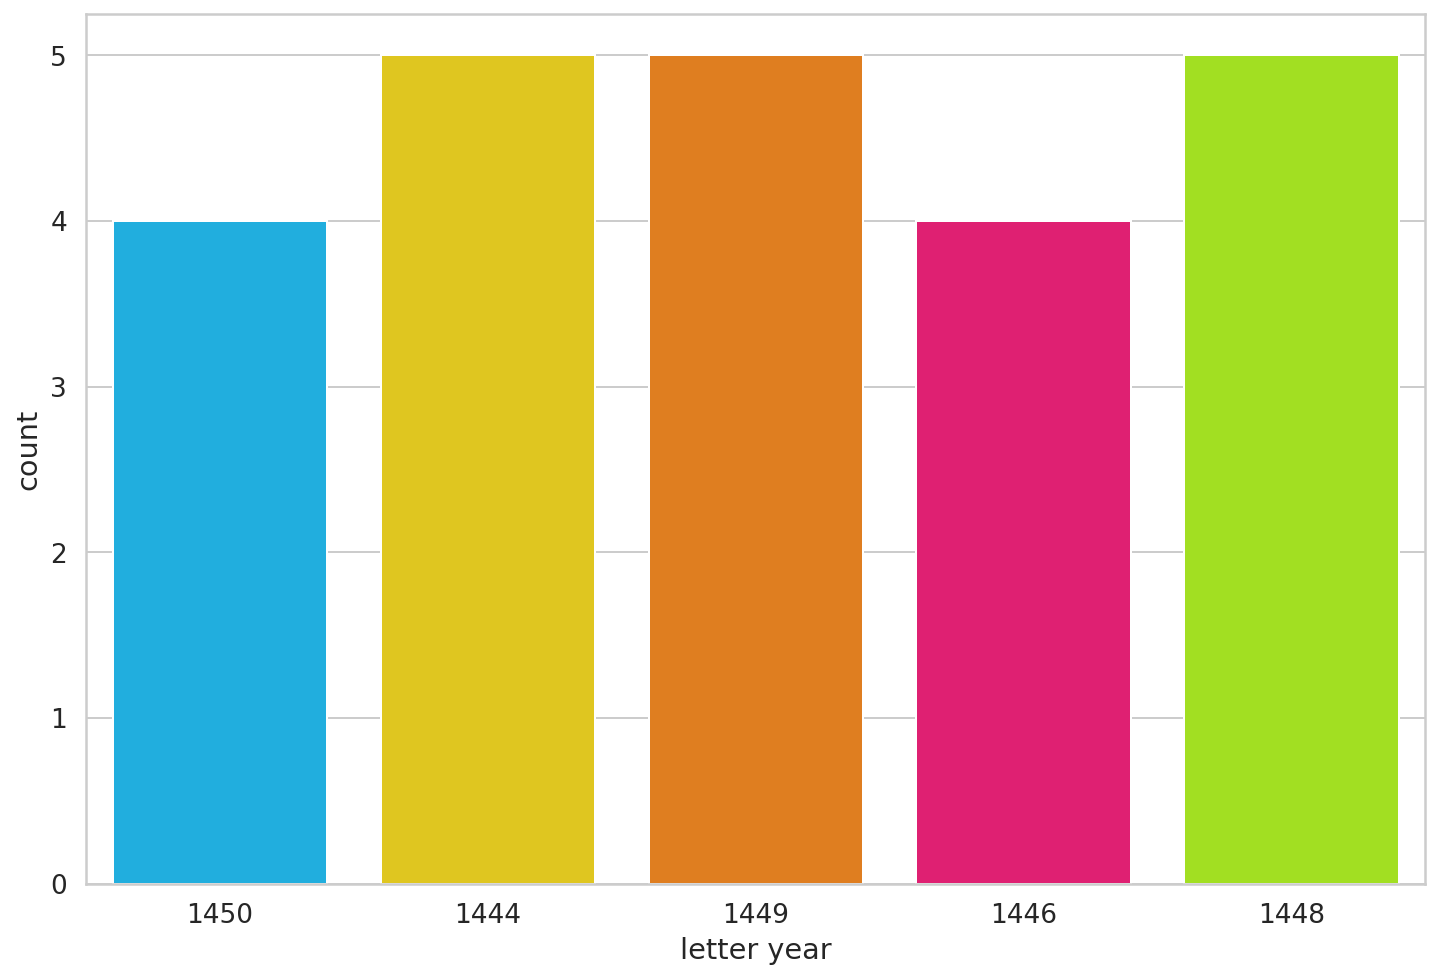

In [98]:
ax = sns.countplot(df2.letter_date)
plt.xlabel(' letter year')
ax.set_xticklabels(class_names);

In [99]:
df2['label'] = df2.letter_date.replace(label_dict)
df2.head(3)

,testo,letter_date,label
0,Avendo ne giorni passati facto risposta a una ...,1450,0
1,Dici non potest Vespasiane suavissime quantum ...,1450,0
2,James cardinal of Papia greets Vespasian Dear ...,1444,1


In [100]:
# df3 = df2.sample(7000, random_state=1).copy()

# df3 = df2.sample(23, random_state=1).copy()
df3 = df2.copy()

In [101]:
df3.reset_index(drop=True, inplace=True)
df3.head(5)

,testo,letter_date,label
0,Avendo ne giorni passati facto risposta a una ...,1450,0
1,Dici non potest Vespasiane suavissime quantum ...,1450,0
2,James cardinal of Papia greets Vespasian Dear ...,1444,1
3,Egli è più dì chio ricevetti una tua alla qual...,1449,2
4,Honorevole come fratello et cetera Quanto più ...,1446,3


## Data Preprocessing

Machine Learning models don't work with raw text. We need to convert text to numbers (of some sort).

Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*


In [102]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [103]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [104]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [105]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [106]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [107]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [108]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [109]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [110]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=256,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [111]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

256


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

The attention mask has the same length:

In [112]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

256


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [113]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [114]:
token_lens = []

for txt in df3.testo:
  tokens = tokenizer.encode(txt, max_length=256)
  token_lens.append(len(tokens))

and plot the distribution:

In [115]:
# sns.distplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [116]:
MAX_LEN = 256

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [117]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [118]:
df_train, df_test = train_test_split(df3, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [119]:
df_train.shape, df_val.shape, df_test.shape

((20, 3), (1, 3), (2, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [120]:
def create_data_loader(df3, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df3.testo.to_numpy(),
    targets=df3.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [121]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [122]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [123]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Date Classification with BERT

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our Date classifier on top of it. Let's load the model:

In [124]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [125]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [126]:
last_hidden_state.shape

torch.Size([1, 256, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [127]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [128]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [129]:
class DateClassifier(nn.Module):

  def __init__(self, n_classes):
    super(DateClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [130]:
model = DateClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data to the GPU:

In [131]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [132]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0691, 0.1863, 0.1053, 0.4669, 0.1723],
        [0.0994, 0.1947, 0.1793, 0.3970, 0.1297],
        [0.1236, 0.1337, 0.1675, 0.4528, 0.1223],
        [0.0456, 0.1262, 0.0810, 0.5906, 0.1565],
        [0.1832, 0.1180, 0.0978, 0.4851, 0.1159],
        [0.0757, 0.1607, 0.1260, 0.4324, 0.2052],
        [0.0867, 0.1262, 0.1452, 0.4583, 0.1836],
        [0.1182, 0.0956, 0.1459, 0.4599, 0.1804],
        [0.1267, 0.0802, 0.1664, 0.4462, 0.1805],
        [0.0879, 0.0767, 0.1503, 0.5573, 0.1279],
        [0.0743, 0.0627, 0.1310, 0.6326, 0.0994],
        [0.1153, 0.0867, 0.1926, 0.3812, 0.2242],
        [0.0380, 0.0981, 0.0776, 0.6592, 0.1272],
        [0.0586, 0.0859, 0.1161, 0.5785, 0.1609],
        [0.0854, 0.1032, 0.1744, 0.5238, 0.1132],
        [0.0453, 0.1558, 0.1859, 0.4581, 0.1549]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [133]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [134]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [135]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [136]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.7456371188163757 accuracy 0.2
Val   loss 1.6755375862121582 accuracy 0.0

Epoch 2/10
----------
Train loss 1.6208587884902954 accuracy 0.1
Val   loss 2.2240989208221436 accuracy 0.0

Epoch 3/10
----------
Train loss 1.6637616157531738 accuracy 0.2
Val   loss 1.7511587142944336 accuracy 0.0

Epoch 4/10
----------
Train loss 1.6102489829063416 accuracy 0.2
Val   loss 1.4645501375198364 accuracy 0.0

Epoch 5/10
----------
Train loss 1.6097670793533325 accuracy 0.30000000000000004
Val   loss 1.4096746444702148 accuracy 0.0

Epoch 6/10
----------
Train loss 1.554444670677185 accuracy 0.35000000000000003
Val   loss 1.3177765607833862 accuracy 0.0

Epoch 7/10
----------
Train loss 1.5595288276672363 accuracy 0.30000000000000004
Val   loss 1.3790167570114136 accuracy 0.0

Epoch 8/10
----------
Train loss 1.4235196113586426 accuracy 0.4
Val   loss 1.4488608837127686 accuracy 0.0

Epoch 9/10
----------
Train loss 1.5573996305465698 accuracy 0.2
Val   loss 1.508

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# # !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = DateClassifier(len(class_names))
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dati/Models/best_model_state.bin'))
# model.load_state_dict(torch.load('./data_volume/finetuned_BERT_epoch_1.model'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting Date? Let's start by calculating the accuracy on the test data:

In [137]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.0

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [138]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [139]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report. Here I face problems which I think it is becaues of poor model. I think because I do not have enough data. I try with another dataset. with more entries for training.

In [140]:
print(classification_report(y_test, y_pred, target_names=class_names))

ValueError: ignored